## Optimal Taxation Simulation - Full Fledged Income Space Approach

---

* This is based on the document John had written up
* Preference family includes income effects

---

In [494]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import pareto
from scipy.optimize import minimize
from scipy import integrate
from scipy.interpolate import interp1d

In [495]:
# some global constants
bin_start = 1.06
nbins = 100
bin = 0.05
eps = 0.5
gamma = 0.5
tol = 1e-3 # tolerance for termination

In [496]:
transfer = 0 # initially

### 1. Prelim


"Today, I feel like doing the Pareto distribution" - Infantino, probably

* Create a discretized version of the Pareto distribution
* Initialize useful helper functions

In [497]:
alpha = 3

In [498]:
def pareto_cdf(x, alpha=3):
    '''
    This is just to evaluate F(x) where F is the cdf of a Pareto with
    alpha = 3, scale = 1, location = -1 (starts at 0)
    '''
    return pareto.cdf(x, alpha, loc=-1, scale=1)

### 2. EGM and Inversion

The utility function we use is:

$$U(c, l) = u(c) + v(l) = \frac{c^{1-\gamma}}{1-\gamma} - \frac{(z/\theta)^{1 + 1/\epsilon}}{1 + 1/\epsilon}$$

s.t.

$$ c \leq \theta \cdot l - T(\theta \cdot l)$$

Note that $T(0) = -R$ is the transfer so there is no need to separately specify the virtual income.

In [499]:
z_grid_length = 1000
z_width = 1e-4

In [500]:
r_primes = [0.35] * z_grid_length # initial R'(z)
ret_func = lambda z: 0.65 * z # initial R(z)

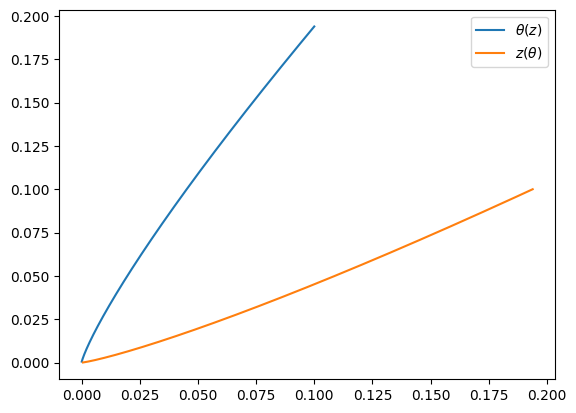

In [501]:
z_grid= [x * z_width for x in range(1, z_grid_length + 1)] # a guess for the realization of z's

theta_grid = []
for index, z in enumerate(z_grid):
    # solve for theta(z)
    theta = ((ret_func(z)**(-1 * gamma)) * r_primes[index] / (z**(1/eps)))**(1/(-1 - 1/eps))
    theta_grid.append(theta)

plt.plot(z_grid, theta_grid, label=r'$\theta(z)$')
plt.plot(theta_grid, z_grid, label=r'$z(\theta)$')
plt.legend()
plt.show()

### 3. Iterating to find the fixed point

#### 3.1 - Intialize a starting tax schedule $(T'(w) \equiv 0.35)$

#### 3.2 - See John's notes  this is exactly step 3 (b) in that procedure

A tricky point is how to deal with $R(z)$, I take the view that we should avoid doing any smoothing for the moment (e.g. polynomial interpolation; kernel ridge; etc.) but just do a linear interpolation

* Why? Tends to preserve concavity / convexity
* Easy to calculate

In [502]:
def apx_derivative(lst, idx, width):
    '''
    Want to get an approximate derivative

    On the edges this is one sided using the nearest neighbor
    In the interior it uses (right - left) / 2 * width
    '''

    if idx == 0:
        return (lst[1] - lst[idx]) / width
    elif idx == len(lst) - 1:
        return (lst[-1] - lst[-2]) / width
    else:
        return (lst[idx + 1] - lst[idx - 1]) / (2 * width)

Iteration 1: revenue (0.013838482907606307) and derivative (0.35)
Iteration 2: revenue (0.016187359908995266) and derivative (0.24499999999999997)
Iteration 3: revenue (0.0026614405034092632) and derivative (0.17149999999999996)
Iteration 4: revenue (0.0017386398397579578) and derivative (0.12004999999999996)


Iteration 5: revenue (0.0010914493657129681) and derivative (0.08403499999999997)
Iteration 6: revenue (0.000636051230310665) and derivative (0.058824499999999974)
Iteration 7: revenue (0.0003140460157168082) and derivative (0.04117714999999998)
Iteration 8: revenue (8.475992118780334e-05) and derivative (0.028824004999999986)
Iteration 9: revenue (8.012209847321067e-05) and derivative (0.02017680349999999)
Iteration 10: revenue (0.00020029971762096366) and derivative (0.014123762449999992)
Iteration 11: revenue (0.0002894676707607749) and derivative (0.009886633714999994)
Iteration 12: revenue (0.0003571357000681022) and derivative (0.006920643600499995)
Iteration 13: revenue (0.0004098970864158738) and derivative (0.004844450520349996)
Iteration 14: revenue (0.000452312621864695) and derivative (0.005470139125596182)


ValueError: This cannot be negative; monotonicity is violated

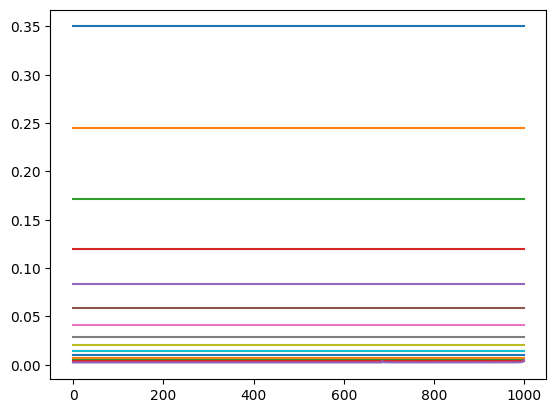

In [503]:
iter = 0

while True:

    plt.plot(r_primes, label=f"{iter}")

    # plt.plot(theta_grid)
    # plt.show()

    max_der_delta = -1 # always positive so this gets dominated
    rev_delta = None

    # we want to calculate the components on RHS

    # again, it serves us computationally to calculate this quantity in reverse...
    # finally, let us assume a flat rate of 0.4 for all incomes above what we use in the z-grid

    # discretize for now

    pmf = []
    
    for index in range(len(theta_grid)):
        if index == 0:
            pmf.append(pareto_cdf(theta_grid[0]))
        else:         
            pmf.append(pareto_cdf(theta_grid[index]) - pareto_cdf(theta_grid[index - 1])) 
        
        if pmf[-1] < 0:
            raise ValueError("This cannot be negative; monotonicity is violated")

    # TODO: Avoid renormalization for top tail and calculate the integral as is
                
    pmf = 1/(np.sum(pmf)) * np.array(pmf)
    cdf = [pmf[0]]

    for mass in pmf[1:]:
        cdf.append(cdf[-1] + mass)
    
    lambda_bar_num = 0 # only the numerator
    eta_bar_num = 0 # only the numerator

    revenue = 0
    new_rates = []

    # plt.plot(z_grid, pmf)
    # plt.show()

    # plt.plot(z_grid, cdf)
    # plt.show()

    # traverse in reverse order 
    for idx, z in enumerate(reversed(z_grid)):

        index = len(z_grid) - 1 - idx # index in the original, not reversed list

        theta_z = theta_grid[index] # theta(z)
        R_z = ret_func(z) # R(z)
        R_prime_z = r_primes[index] # R'(z)

        alpha_z_num = pmf[index] * z # modified; denominator incorporated later

        dlogRz_dlogz = z / R_z * R_prime_z
        dlogRpz_dlogz = z / R_prime_z * apx_derivative(r_primes, index, z_width)
        eps_z = eps / (1 - eps * dlogRpz_dlogz + eps * gamma * dlogRz_dlogz)
        eta_z = eps_z * (-gamma)

        eta_bar_num += (1 - R_prime_z) * z / R_z * eta_z * pmf[index]
        lambda_bar_num += (R_z**(-gamma) * pmf[index])

        rhs = ((1 - cdf[index]) - (lambda_bar_num + eta_bar_num)) / (alpha_z_num * eps_z)
        new_rate = min(max(1 / (1 + rhs), 0), 1)

        new_rates.append((new_rate * 0.3 + R_prime_z * 0.7))

        if abs(new_rate - R_prime_z) > max_der_delta:
            max_der_delta = abs(new_rate - R_prime_z)

        revenue += (z - R_z) * pmf[index]

    rev_delta = abs(transfer - revenue)
    transfer = revenue

    # check for termination
    
    print(f"Iteration {iter + 1}: revenue ({rev_delta}) and derivative ({max_der_delta})")

    if rev_delta < tol and max_der_delta < tol:
        break

    # construct new R(Z) function from r'(z)
    # interpolate a piece-wise linear function?

    r_primes = new_rates[::-1] # since the rates were added in reverse order

    def new_ret_func(z):
        '''
        Construct the retention function from R'(z)
        Currently just linear. Consider trapezoidal? Shouldn't matter if the grid is fine...
        
        TODO: note that this always comes from the same grid, so just compute for values in the grid...
        '''
        prev_cutoff = 0
        total = 0
        for idx, rate in enumerate(r_primes):
            if z <= z_grid[idx]:
                total += (z - prev_cutoff) * rate
                break
            else:
                total += (z_grid[idx] - prev_cutoff) * rate
                prev_cutoff = z_grid[idx]

        if z > z_grid[-1]:
            total += (z - z_grid[-1]) * r_primes[-1]
        
        return total
    
    ret_dict = {}
    for z in z_grid:
        ret_dict[z] = new_ret_func(z)
    ret_func = lambda z: ret_dict[z]

    theta_grid = []

    for index, z in enumerate(z_grid):
        # solve for theta(z)
        theta = ((ret_func(z)**(-1 * gamma)) * r_primes[index] / (z**(1/eps)))**(1/(-1 - 1/eps))
        theta_grid.append(theta)

    iter += 1

plt.legend()
plt.show()